# Practical Machine Learning for Physicists
## Coursework C - Part 2


For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to  Moodle. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.15.0


In [ ]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):

    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)

    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)

    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!

        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)

    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)

    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")

def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features

## Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.



In this task, my aim was to achieve the lowest cost value, while considering the runtime of the code. Increasing the filter and kernal sizes in the neural network to a value too high resulted in an unefficiently long runtime (5mins>), as a result, through a process of trial and error, I was able to optimize my cost value to approximately 0.00399 for a 9 neuron bottleneck.

## Circle generator


In [ ]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def my_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )

In [ ]:
# Building a simple neural network
model=keras.models.Sequential()

model.add(keras.layers.Conv2D(14,8,input_shape=(None,None,1),
               activation="relu",padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model.add(keras.layers.Conv2D(28,8,
               activation="relu",padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model.add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) # up
model.add(keras.layers.Conv2D(28,8,
               activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) # up
model.add(keras.layers.Conv2D(14,8,
               activation="relu",padding='same'))
model.add(keras.layers.Conv2D(1,3,activation="relu",padding='same'))

model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, None, None, 14)    910       
                                                                 
 average_pooling2d_4 (Avera  (None, None, None, 14)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 28)    25116     
                                                                 
 average_pooling2d_5 (Avera  (None, None, None, 28)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 1)     253       
                                                                 
 up_sampling2d_4 (UpSamplin  (None, None, None, 1)    

Text(0.5, 1.0, '')

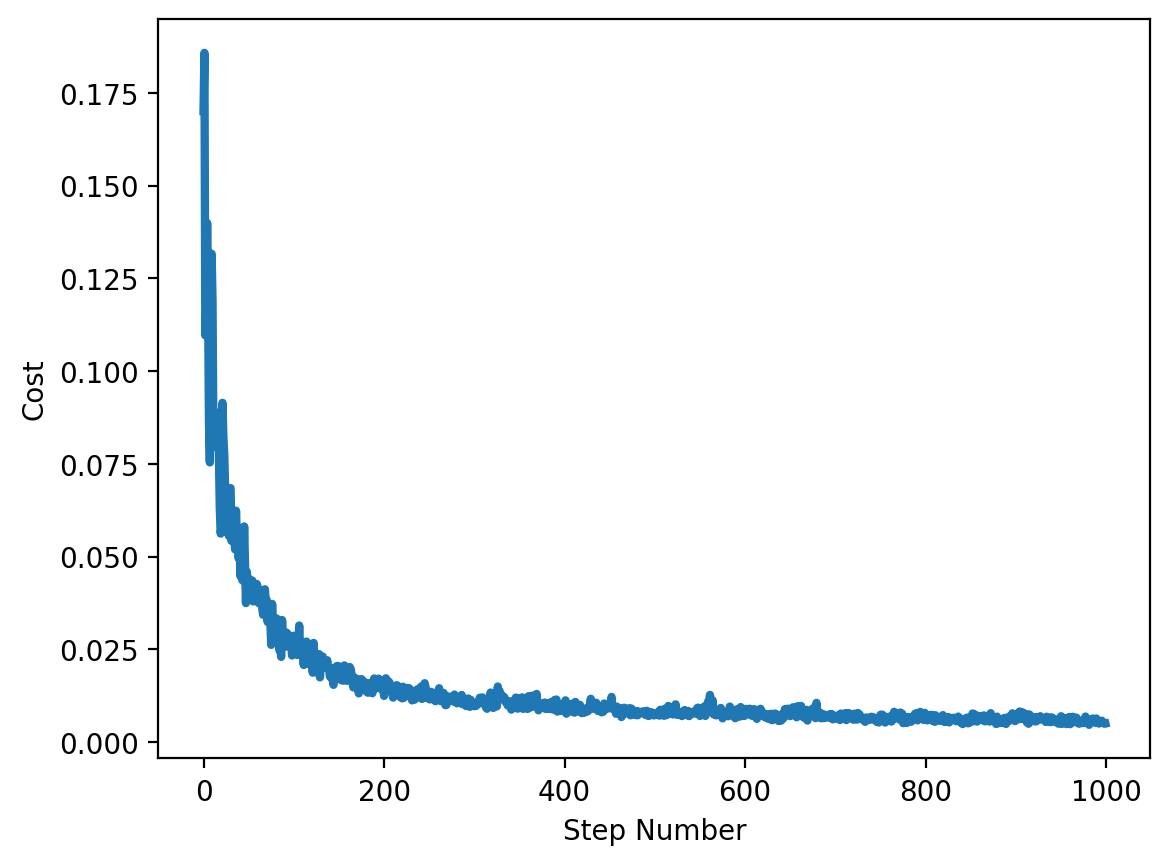

In [ ]:
#model training
steps=1000
cost,y_target=generate_and_train(model,my_generator,img_size=9*3,batchsize=30,steps=steps)
#Plotting the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps)
ax.plot(stepArray,cost,linewidth=3)
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")
ax.set_title("")


In [3]:
print(cost[-1])

0.003990014247596264


In [ ]:
print_layers(model,y_target)

Layer 0: 10206 neurons /  (30, 27, 27, 14)
Layer 1: 1134 neurons /  (30, 9, 9, 14)
Layer 2: 2268 neurons /  (30, 9, 9, 28)
Layer 3: 252 neurons /  (30, 3, 3, 28)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 81 neurons /  (30, 9, 9, 1)
Layer 6: 2268 neurons /  (30, 9, 9, 28)
Layer 7: 20412 neurons /  (30, 27, 27, 28)
Layer 8: 10206 neurons /  (30, 27, 27, 14)
Layer 9: 729 neurons /  (30, 27, 27, 1)


## Task 2:

In this task 2, my approach was similar to task 1, I changed the pool sizes and upsampling sizes to produce a 10 layer network with a 3 neuron bottleneck reaching a final cost of 0.0067. This was accomplished again through a process of trial and error, changing the kernal and filter parameters.


In [ ]:
model2=keras.models.Sequential()
# 3x3 kernel size, 10 channels in first hidden layer:
model2.add(keras.layers.Conv2D(10,8,input_shape=(None,None,1),
               activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(4,4),padding='same')) # down
model2.add(keras.layers.Conv2D(18,8,
               activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(7,7),padding='same')) # down

model2.add(keras.layers.Conv2D(3,1,
               activation="relu",padding='same'))

model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(18,8,
               activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(9,9))) # up
model2.add(keras.layers.Conv2D(10,8,
               activation="relu",padding='same'))
model2.add(keras.layers.Conv2D(4,3,activation="relu",padding='same'))

model2.compile(loss='mean_squared_error',
              optimizer='adam')
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, None, None, 10)    650       
                                                                 
 average_pooling2d_6 (Avera  (None, None, None, 10)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 18)    11538     
                                                                 
 average_pooling2d_7 (Avera  (None, None, None, 18)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_20 (Conv2D)          (None, None, None, 3)     57        
                                                                 
 up_sampling2d_6 (UpSamplin  (None, None, None, 3)    

Text(0, 0.5, 'Cost')

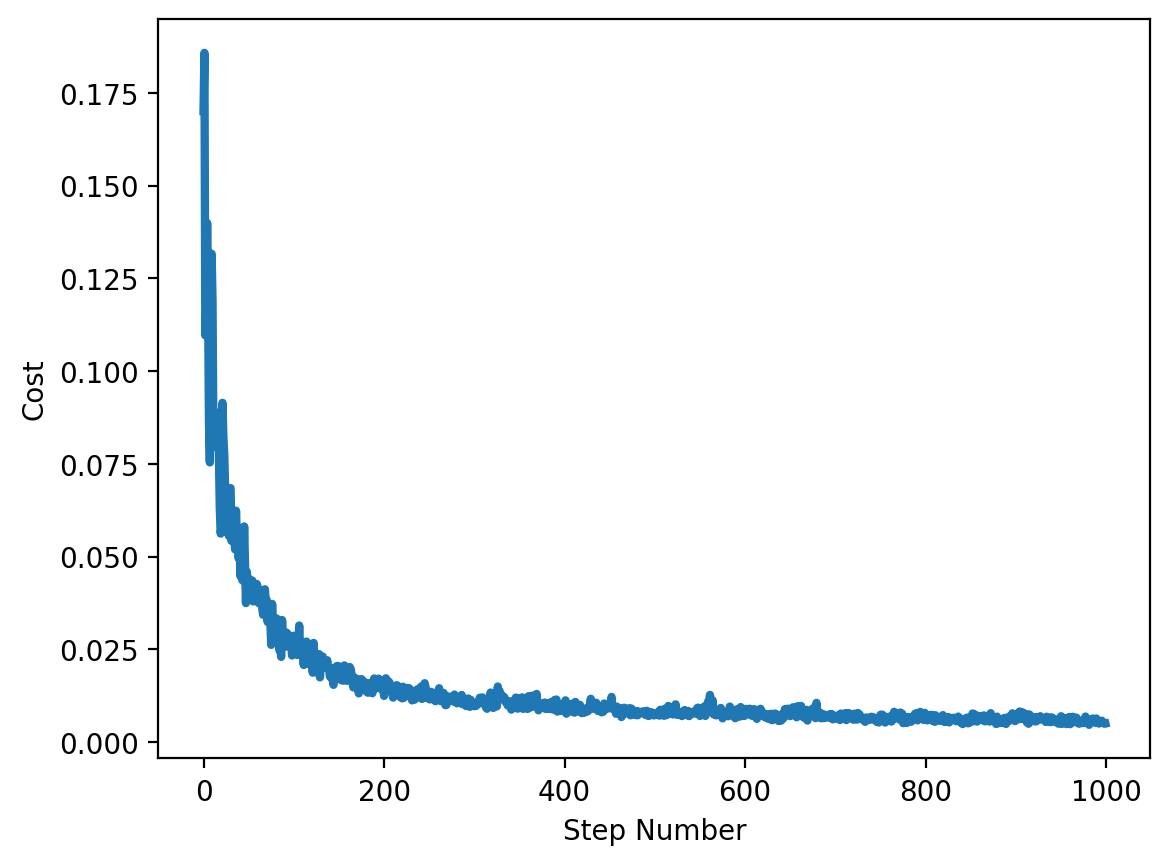

In [ ]:
#Now we can do the actual model training
steps=1000
cost2,y_target = generate_and_train(model2,my_generator,img_size=9*3,batchsize=30,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps)
ax.plot(stepArray,cost,linewidth=3)
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")

In [5]:
print(cost2[-1])

0.006724878519773484


In [ ]:
print_layers(model2,y_target)

Layer 0: 7290 neurons /  (30, 27, 27, 10)
Layer 1: 490 neurons /  (30, 7, 7, 10)
Layer 2: 882 neurons /  (30, 7, 7, 18)
Layer 3: 18 neurons /  (30, 1, 1, 18)
Layer 4: 3 neurons /  (30, 1, 1, 3)
Layer 5: 27 neurons /  (30, 3, 3, 3)
Layer 6: 162 neurons /  (30, 3, 3, 18)
Layer 7: 13122 neurons /  (30, 27, 27, 18)
Layer 8: 7290 neurons /  (30, 27, 27, 10)
Layer 9: 2916 neurons /  (30, 27, 27, 4)


## Commment:

The primary trade-off addressed in this notebook revolves around the compromise between network efficiency and cost considerations. Opting for more intricate networks featuring larger neurons and filters per layer tends to yield lower cost values. However, this advantage is counterbalanced by the drawback of increased runtimes, leading to potential inefficiencies, particularly depending on the task at hand. Striking a delicate balance between these two objectives becomes imperative to derive the most optimal network architecture for a given application.

# Conclusion:

In conclusion, this notebook effectively implemented and trained autoencoder networks for two tasks involving randomly generated circles, each with specific bottleneck size constraints. Task 1, with a bottleneck limit of 9 neurons, yielded a well-optimized model achieving a final cost of approximately 0.00399. For Task 2, which imposed a more stringent constraint of no more than 3 neurons in the bottleneck, the implemented network reached a final cost of about 0.0067. Notably, a crucial observation emerged regarding the impact of the activation function on the network's training. Switching from sigmoid to ReLU significantly lowered the cost value in both tasks, underscoring the importance of thoughtful activation function selection in neural network design.